# Latent Diffusion Model

`02.vae_latent_2d.ipynb` 파일에서 학습 데이터를 잠재변수로 만들었습니다. [en] In the `02.vae_latent_2d.ipynb` file, the training data was transformed into latent variables.


<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/ldm-figure3.png" width=700>


이제 위 그림을 구현할 모든 준비를 마쳤습니다. 앞서 만든 VAE로 그림 왼편 Pixel Space 부분을 처리하고 DDPM에서 만들어 본 노이즈 제거 모델을 사용해서 Latent Space 부분을 처리합니다. [en] Now, we have completed all the parts to implement the above figure. The VAE created earlier will handle the Pixel Space section on the left side of the figure, while the denoising model from the DDPM will handle the Latent Space section.

단일 단어로 구성된 이미지의 레이블은 컨디션이 되어서 그림의 $\tau_\theta$에 의해 임베딩 벡터로 바뀌게 됩니다. DDPM을 구현할 때 이 임베딩 벡터는 CNN의 특징맵feature map에 단순히 더해졌지만 여기서는 멀티헤드어텐션을 사용하여 피처맵에 추가되는 방식으로 구현합니다. 물론 그럼처럼 잠재변수에 바로 concat으로 추가될 수도 있습니다. 두 방식 모두 구현하도록 하겠습니다. [en] The labels of images, consisting of single words, act as conditions and are converted into embedding vectors by $\tau_\theta$ in the figure. When implementing DDPM, these embedding vectors were simply added to the feature map of the CNN. However, we will implement this by incorporating the embedding vectors into the feature map using multi-head attention. Of course, as in the previous method, they can also be directly concatenated to the latent variables. We will implement both approaches.

In [1]:
# import the necessary packages
import os, random, shutil

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
from matplotlib.animation import FuncAnimation, PillowWriter

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare Dataset


In [2]:
!gdown 1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
!gdown 1gAY7uXhe6jBRv0NMk7iXWKRln-nPjo4s

Downloading...
From: https://drive.google.com/uc?id=1gADYmo2UXlr24dUUNaqyPF2LZXk1HhrJ
To: /content/sprites_1788_16x16.npy
100% 68.7M/68.7M [00:03<00:00, 17.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gAY7uXhe6jBRv0NMk7iXWKRln-nPjo4s
To: /content/sprite_labels_nc_1788_16x16.npy
100% 3.58M/3.58M [00:00<00:00, 216MB/s]


In [4]:
sprites = np.load('sprites_1788_16x16.npy')
sprite_labels = np.load('sprite_labels_nc_1788_16x16.npy').astype(np.float32)

In [5]:
IMAGE_SIZE = 16
CHANNELS = 3
LATENT_EMB_DIM = 4
LATENT_HEIGHT = 8
LATENT_WIDTH = 8
CTX_LEN = 5

LABEL_NAMES = np.array(['hero', 'non-hero', 'food', 'spell', 'side-facing'])

## VAE Model

앞서 만들어둔 VAE를 복원합니다. 모델을 정의한 소스를 그대로 복사하고 학습 후 백업한 파라미터 파일을 이용합니다.

In [6]:
# define a convolutional block for the encoder part of the vae
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()

        # sequential block consisting of a 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels,  # number of input channels
                out_channels=out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        # pass the input through the sequential block
        return self.block(x)

# define a transposed convolutional block for the decoder part of the vae
class ConvTBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        super().__init__()

        # sequential block consisting of a transposed 2d convolution,
        # batch normalization, and leaky relu activation
        self.block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels,  # number of input channels
                out_channels,  # number of output channels
                kernel_size=kernel_size,  # size of the convolutional kernel
                stride=stride,  # stride of the convolution
                padding=padding,  # padding added to the input
                output_padding=output_padding,  # additional padding added to the output
            ),
            torch.nn.BatchNorm2d(out_channels),  # normalize the activations of the layer
            torch.nn.LeakyReLU(),  # apply leaky relu activation
        )

    def forward(self, x):
        return self.block(x)  # pass the input through the sequential block

# define the main vae class
class VAE(torch.nn.Module):
    """
    image          encoder        latent       decoder         final layer
    (3, 16, 16) -> (128, 8, 8) -> (4, 8, 8) -> (128, 16, 16) -> (16, 16, 16) -> (3, 16, 16)
    """
    def __init__(self, in_channels, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim  # dimensionality of the latent space
        hidden_dims = [128,]  # hidden dimensions
        # img size     8

        self.encoder = torch.nn.Sequential(
            # (3,16,16) -> (128,8,8)
            ConvBlock(in_channels, hidden_dims[0]),
            # hidden_dims에 추가 레이어가 있으면 [en] If there are additional layers in hidden_dims
            # ConvBlock(hidden_dims[0], hidden_dims[1]),
            # ConvBlock(hidden_dims[1], hidden_dims[2]), ...
        )

        # layer for the mean of the latent space
        self.conv_mu = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)

        # layer for the variance of the latent space
        self.conv_var = torch.nn.Conv2d(hidden_dims[-1], latent_dim, kernel_size=3, stride=1, padding=1)


        self.decoder = torch.nn.Sequential(
            ConvTBlock(latent_dim, hidden_dims[-1]),
            # hidden_dims에 추가 레이어가 있으면 [en] If there are additional layers in hidden_dims
            # ConvTBlock(hidden_dims[-1], hidden_dims[-2]),
            # ConvTBlock(hidden_dims[-2], hidden_dims[-3]), ...
        )

        # final layer to reconstruct the original input
        self.final_layer = torch.nn.Sequential(
            torch.nn.Conv2d(
                hidden_dims[0], hidden_dims[0],
                kernel_size=3, stride=1, padding=1
            ),

            # normalize the activations of the layer
            torch.nn.BatchNorm2d(hidden_dims[0]),

            # apply leaky relu activation
            torch.nn.LeakyReLU(),

            # final convolution to match the output channels
            torch.nn.Conv2d(hidden_dims[0], out_channels=3, kernel_size=3, stride=1, padding=1),
        )

    # encoding function to map the input to the latent space
    def encode(self, input):
        # pass the input through the encoder
        result = self.encoder(input) # (B,3,16,16)->(B,128,8,8)

        # compute the mean of the latent space
        mu = self.conv_mu(result) # (B,128,8,8)->(B,4,8,8)

        # compute the log variance of the latent space
        log_var = self.conv_var(result) # (B,128,8,8)->(B,4,8,8)

        return [mu, log_var]

        # decoding function to map the latent space to the reconstructed input
    def decode(self, z):
        # pass the result through the decoder
        result = self.decoder(z) # (B,4,8,8) -> (B,128,16,16)

        # pass the result through the final layer
        result = self.final_layer(result) # (B,128,16,16)->(B,128,16,16)->(B,3,16,16)
        return result

        # reparameterization trick to sample from the latent space
    def reparameterize(self, mu, logvar):
        # compute the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        # sample random noise
        eps = torch.randn_like(std)
        # compute the sample from the latent space
        return eps * std + mu

    # forward pass of the vae
    def forward(self, input):
        # encode the input to the latent space
        mu, log_var = self.encode(input) # (B, 3, 16, 16) -> [(B, 4, 8, 8), (B, 4, 8, 8)]

        # sample from the latent space
        z = self.reparameterize(mu, log_var) # [(B, 4, 8, 8), (B, 4, 8, 8)] -> (B, 4, 8, 8)

        # decode the sample, and return the reconstruction
        # along with the original input, mean, and log variance
        recon_input = self.decode(z) # (B, 4, 8, 8) -> (B, 3, 16, 16)

        return [recon_input, input, mu, log_var]

In [7]:
# download vae weights best_vae.pt
!gdown 1bGhqQB30EurDt9b_ZsKML51jk-Y55Fio

Downloading...
From: https://drive.google.com/uc?id=1bGhqQB30EurDt9b_ZsKML51jk-Y55Fio
To: /content/best_vae.pt
100% 690k/690k [00:00<00:00, 106MB/s]


In [8]:
# create output directory
output_dir = "assets"
os.makedirs(output_dir, exist_ok=True)

vae_weights_dir = os.path.join(output_dir, f"vae_latent_2d_emb{LATENT_EMB_DIM}")
os.makedirs(vae_weights_dir, exist_ok=True)

VAE_BEST_WEIGHTS_PATH = os.path.join(vae_weights_dir, "best_vae.pt")


In [9]:
# move best_vae.pt to VAE_BEST_WEIGHTS_PATH
import shutil

if os.path.exists("./best_vae.pt"):
    shutil.move("./best_vae.pt", VAE_BEST_WEIGHTS_PATH)

이미지 파일을 모두 잠재 변수 $z$로 바꿀것이기 때문에 VAE모델에 이미지를 공급할 `Dataset`을 정의합니다.

In [10]:
class MyVaeDataset(Dataset):
    def __init__(self, data, sprite_labels, transform=None):
        self.data = data
        self.labels = sprite_labels
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        x_0 = self.data[i]
        label = self.labels[i]

        if self.transform:
            x_0 = self.transform(x_0)

        return x_0, label

In [11]:
# Define the transformations
valid_transforms = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

def set_seed(seed_value=42):
    random.seed(seed_value)  # Python
    np.random.seed(seed_value)  # Numpy
    torch.manual_seed(seed_value)  # PyTorch
    torch.cuda.manual_seed_all(seed_value)  # Pytorch All GPU

seed = 100
set_seed(seed)  # 시드 값을 설정합니다.

VAE_BATCH_SIZE = 32

train_ds = MyVaeDataset(sprites, sprite_labels, valid_transforms)
train_loader = DataLoader(train_ds, batch_size=VAE_BATCH_SIZE, shuffle=False)

Dataset이 잘 작동하는지 이미지를 그려 확인합니다.

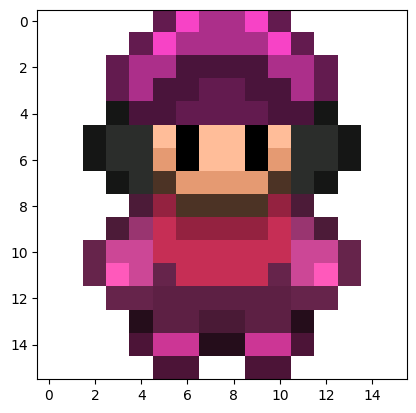

In [12]:
# 샘플 확인
plt.imshow(train_ds[0][0].permute(1,2,0))
plt.show()

### Test VAE

In [13]:
# make vae
vae = VAE(CHANNELS, LATENT_EMB_DIM)

# load parameters
model_state = torch.load(VAE_BEST_WEIGHTS_PATH, weights_only=True)
vae.load_state_dict(model_state['vae'])
vae.eval();

torch.Size([5, 3, 16, 16])
torch.Size([5, 3, 16, 16])


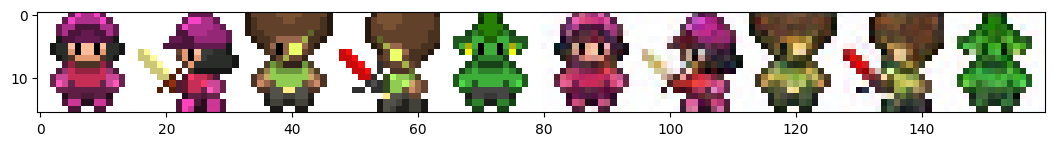

In [14]:
# Reconstruction experiments of the VAE
val_loader_iter = iter(train_loader)
x_test = next(val_loader_iter)[0][:5].clone()
print(x_test.shape)

predictions = vae(x_test)
print(predictions[0].shape)

fig = plt.figure(figsize=(13,5))
plt.imshow(torch.cat([x_test, predictions[0]]).permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

LDM(Latent Diffusion Model)은 VAE를 거친 잠재변수에 노이즈를 추가하고 추가된 노이즈를 제거하는 모델이기 때문에 데이터 셋에 있는 모든 이미지를 잠재변수로 변환합니다. [en] The LDM (Latent Diffusion Model) adds noise to the latent variables obtained from the VAE and removes the added noise. Therefore, all images in the dataset are converted into latent variables.

In [ ]:
# 모든 데이터를 latent z로 만들기 [en] Encode all data into latent z
# 데이터셋의 미니배치 사이즈 32이므로 32장씩 변환 [en] Convert in batches of 32 as the dataset's mini-batch size is 32.
vae.to(device)

latents = []
labels = []

for i, D_batched in enumerate(tqdm(train_loader)):
    X_batched = D_batched[0].to(device)
    y_batched = D_batched[1]

    mu, log_var = vae.encode(X_batched)
    z = vae.reparameterize(mu, log_var)
    z = z.detach().cpu()
    latents.append(z)
    labels.append(y_batched)

100%|███████████████████████████████████████████████████████████████████| 2794/2794 [00:03<00:00, 814.87it/s]


변환된 잠재변수는 32개씩 2794세트가 있으므로 이를 모두 이어 붙여 전체 데이터 셋을 구성합니다.

In [ ]:
# 변환된 잠재 변수 개수와 잠재변수의 모양 [en] Number of converted latent variables and their shape
len(latents), latents[0].shape

(2794, torch.Size([32, 4, 8, 8]))

In [ ]:
# concat
latents = torch.cat(latents, axis=0)
labels = torch.cat(labels, axis=0)
latents.shape, latents.device, labels.shape, labels.device

(torch.Size([89400, 4, 8, 8]),
 device(type='cpu'),
 torch.Size([89400, 5]),
 device(type='cpu'))

### Latent variable reconstruction experiment

변환된 전체 데이터 셋에서 임의로 5개를 가져와 VAE로 복원해보겠습니다. [en] Randomly select 5 samples from the converted dataset and reconstruct them using the VAE.

torch.Size([5, 4, 8, 8])
torch.Size([5, 3, 16, 16])


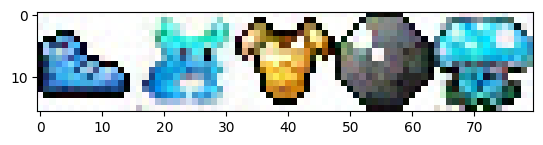

array(['spell', 'non-hero', 'spell', 'spell', 'non-hero'], dtype='<U11')

In [ ]:
shuffled_indices = torch.randperm(latents.size(0))
latents = latents[shuffled_indices]
labels = labels[shuffled_indices]

x_test = latents[:5].to(device)
print(x_test.shape)

predictions = vae.decode(x_test)
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

LABEL_NAMES[np.argmax(labels[:5].numpy(), axis=1)]

복원된 이미지와 레이블이 잘 일치하는지 확인합니다. 잘 일치하는것 같습니다.

이것으로 VAE에 대한 준비는 마쳤습니다. 이제 노이즈 제거 모델을 정의하고 학습하겠습니다.

## Latent Diffusion Model

### Dataset and DataLoader

In [ ]:
class MyDataset(Dataset):
    # beta는 DDPM 원문의 설정을 따름
    # [en] Beta follows the settings from the original DDPM paper.
    beta_1 = 1e-4
    beta_T = 0.02
    # 시간 단계는 deeplearning.ai에서 제공하는 숏코스 How Diffusion Models Work의 설정을 따름
    # [en] Time steps follow the settings from deeplearning.ai's short course "How Diffusion Models Work"
    T = 500

    # beta는 첨자 1부터 T까지 사용하기 위해 제일 앞에 더미 데이터 tf.constant([0.])를 추가하여 만듬
    # [en] Beta is created by adding dummy data tf.constant([0.]) at the beginning to use subscripts from 1 to T
    beta = torch.cat([ torch.tensor([0]), torch.linspace(beta_1, beta_T, T)], axis=0)
    alpha = 1 - beta
    alpha_bar = torch.exp(torch.cumsum(torch.log(alpha), axis=0))

    labels = LABEL_NAMES

    def __init__(self, data, ctx, transform=None):
        self.data = data
        self.transform = transform
        self.ctx = ctx

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        x_0 = self.data[i]
        ctx = self.ctx[i]
        label = MyDataset.labels[np.argmax(ctx)]

        # 잠재변수를 normalize -1~1로 만들기
        if self.transform:
            x_0 = self.transform(x_0)

        # noise 추가
        t = np.random.randint(1, MyDataset.T+1)
        eps = torch.randn_like(x_0)
        x_t = torch.sqrt(MyDataset.alpha_bar[t]) * x_0 + torch.sqrt(1 - MyDataset.alpha_bar[t]) * eps

        return x_0, x_t, eps, t, ctx, label

In [ ]:
BATCH_SIZE = 256

# 잠재변수에 대한 Transform은 필요없음
# [en] No transformation needed for latent variables
train_ds = MyDataset(latents, labels, None)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)#, num_workers=2)
train_loader_iter = iter(train_loader)

정의된 데이터로더로 부터 임의의 데이터 5개를 가져와서 각 항목의 텐서 모양과 데이터를 확인합니다.

In [ ]:
samples = next(train_loader_iter)

x_0s = samples[0][:6].numpy()
x_ts = samples[1][:6].numpy()
epss = samples[2][:6].numpy()
ts =  samples[3][:6].numpy()
ctx = samples[4][:6].numpy()
labels = samples[5][:6]

In [ ]:
x_0s.shape, x_ts.shape, epss.shape, ts

((6, 4, 8, 8),
 (6, 4, 8, 8),
 (6, 4, 8, 8),
 array([  9, 281, 324, 360, 344,  80], dtype=int64))

In [ ]:
ctx, labels

(array([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]], dtype=float32),
 ('spell', 'non-hero', 'non-hero', 'non-hero', 'spell', 'non-hero'))

데이터로더에서 가져온 원본 잠재변수 $\mathbf{x}_0$를 VAE로 디코딩 해봅니다.

torch.Size([6, 3, 16, 16])


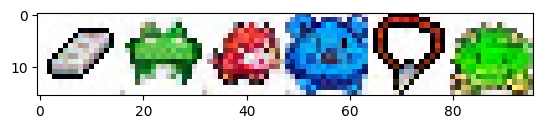

In [ ]:
# 원본 잠재 변수 x0를 디코딩
# [en] Decode the original latent variables x0
predictions = vae.decode(torch.tensor(x_0s).to(device))
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

이번에는 $\mathbf{x}_0$에 잡음이 추가된 $\mathbf{x}_t$를 디코딩 해보겠습니다.

결과를 보면 $\mathbf{x}_0$는 잘 복원이 되지만 잡음이 추가된 $\mathbf{x}_t$는 잘 복원하지 못하는 것을 알 수 있습니다. 이 결과로 부터 가우시안 노이즈에서 노이즈를 제거하여 잠재변수로 만들어주는 노이즈 제거 모델이 있으면 이 모델과 VAE를 함께 사용하여 이미지를 생성할 수 있다는 것을 확실히 이해할 수 있습니다.

torch.Size([6, 3, 16, 16])


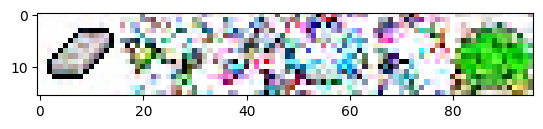

In [ ]:
# 원본 잠재변수에 잡음이 추가된 xt를 디코딩
# [en] Decode xt, the original latent variables with added noise
predictions = vae.decode(torch.tensor(x_ts).to(device))
print(predictions.shape)

plt.imshow(predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1))
plt.show()

### Convolution Block

이미지 인코더와 디코더에 사용할 컨볼루션 레이어 블록을 정의 합니다. 다음 세종류의 블록으로 구성됩니다.

- `UnetConv`: 입력 사이즈를 줄이지 않는 더블 컨볼루션 블록
- `UnetDownConv`: 입력 사이즈를 반으로 줄이는 더블 컨볼루션 블록
- `UnetUpConv`: 입력 사이즈를 두배로 늘리는 트리플 컨볼루션 블록

각 컨볼루션 블록은 내부적으로 스킵 커넥션 구조를 가지고 있습니다. 이는 `ResidualConvBlock`이 담당합니다.

In [ ]:
class ResidualConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, is_res = True):
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = torch.nn.Sequential(
            # 3x3 kernel with stride 1 and padding 1
            torch.nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),   # Batch normalization
            torch.nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = torch.nn.Sequential(
            # 3x3 kernel with stride 1 and padding 1
            torch.nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            torch.nn.BatchNorm2d(out_channels),   # Batch normalization
            torch.nn.GELU(),   # GELU activation function
        )

    def forward(self, x):
        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer
                # to match dimensions before adding residual connection
                shortcut = torch.nn.Conv2d(x.shape[1], x2.shape[1],
                                     kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            # print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor, 분산을 1로 만들기 위해
            return out / 1.414 # sqrt(2)

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

class UnetConv(torch.nn.Module):
    # 입력 사이즈를 줄이지 않는 더블 컨볼루션
    def __init__(self, in_channels, out_channels):
        super().__init__()

        layers = [
            ResidualConvBlock(in_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels)
        ]

        # Use the layers to create a sequential model
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class UnetDownConv(torch.nn.Module):
    # 입력 사이즈를 반으로 줄이는 더블 컨볼루션
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers,
        # followed by a MaxPool2d layer for downsampling
        layers = [
            ResidualConvBlock(in_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
            torch.nn.MaxPool2d(2)
        ]

        # Use the layers to create a sequential model
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class UnetUpConv(torch.nn.Module):
    # 입력 사이즈를 두배로 늘리는 트리플 컨볼루션
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.layers = torch.nn.ModuleList([
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            torch.nn.GroupNorm(out_channels//8, out_channels), # normalize
            torch.nn.GELU(),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ])

    def forward(self, x, output_size=None):
        for i, layer in enumerate(self.layers):
            if i == 0:
                # 첫번째 컨볼루션은 이미지 사이즈를 줄이는데
                # 외부에서 넘겨준 사이즈에 맞게 조정
                x = layer(x, output_size=output_size)
            else:
                # 나머지 레이어는 그냥 진행하면 됨
                x = layer(x)

        return x

### Condition Encoder $\tau_\theta$

<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/ldm-figure3.png" width=700>

그림을 보면 모델은 각종 컨디션을 인코딩해서 모델에 공급할 컨디션 인코더 $\tau_\theta$가 필요합니다. DDPM 구현에서는 $\tau_\theta$에 해당하는 부분을  `Linear` 레이어로 모델 내부에 구현했지만 여기서는 따로 만들도록 하겠습니다.

$\tau_\theta$는 특별한 구조없이 컨디션 벡터를 `Linear`레이어 두개로 피드포워드 시키는 MLP 입니다.

In [ ]:
class CondEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.ctx_emb_1 = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.ctx_emb_2 = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, ctx):
        ctx = self.relu( self.ctx_emb_1(ctx) )
        ctx = self.relu( self.ctx_emb_2(ctx) )

        return ctx


### LDM Class

이번에는 LDM 클래스를 정의합니다. 여기서는 $\tau_\theta(y)$를 처리하는 매커니즘을 제외하고는 DDPM과 완전히 동일합니다.

LDM 모델의 손실은 다음처럼 정의됩니다.

$$
L_{LDM} := \mathbb{E}_{\mathcal{E}(x), y, \epsilon \sim \mathcal{N}(0,1), t}
\left[
\left\|
\epsilon - \epsilon_\theta(z_t, t, \tau_\theta(y))
\right\|_2^2
\right]
$$

모델은 잠재변수 $z_t$, 시간 단계 $t$, 컨디션 인코더 $\tau_\theta(y)$의 출력을 입력받아 노이즈를 출력합니다. 입력된 $\tau_\theta(y)$를 초기 잠재변수에 채널 방향으로 concat할지 컨볼루션 블록의 출력 특징맵에 크로스 어텐션할지에 따라 동작 방식이 달라지게 됩니다.

코드를 살펴보기 전에 이미지 데이터와 컨디션 임베딩 벡터 간에 크로스 어텐션이 어떻게 작동하는지 확인해보도록 하겠습니다.


#### Cross attention

컨디션 인코더 $\tau_\theta(y)$의 출력 차원은 $(M \times d_{\tau})$로 표시합니다. 여기서 $M$은 컨디션의 시퀀스 길이가 됩니다.

$$
\tau_{\theta}(y) \in \mathbb{R}^{M \times d_{\tau}}
$$

예를 들어 이미지 생성을 위한 컨디션 문장이 "brave hero"이고 공백을 기준으로 토큰화 한다면 $M=2$입니다. $d_\tau$는 한 토큰이 임베딩된 임베딩 벡터의 길이입니다. $\tau_{\theta}(y)$를 이미지로 만들어진 텐서에 컨디션으로 주입해야 되기 때문에 $\tau_{\theta}(y)$가 어텐션에서 키와 벨류가 됩니다.

쿼리는 U-Net을 통과하는 특징맵이 될텐데 이를 원 논문에서 $\varphi_i(z_t)$로 표현합니다. 여기서 $t$는 노이즈의 시간단계를 나타내고 $i$는 U-Net의 레이어 번호입니다. 즉 $i$번째 레이어의 출력입니다. 모양은 다음과 같고

$$
\varphi_i(z_t) \in \mathbb{R}^{N \times d^{i}_{\epsilon}}
$$

$N$은 특징맵의 시퀀스 길이, $d^{i}_{\epsilon}$은 $i$번째 노이즈 제거 레이어가 출력하는 특징맵의 채널 수 입니다. 이를 그림으로 나타내면 다음과 같습니다. 그림에서 $B$는 미니 배치 사이즈를 나타냅니다.


<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/featuremap-tau.png" width=950 align="center">
</div>


특징맵은 3차원 텐서인데 이를 어텐션 레이어에 입력하기 위해 아래 그림처럼 공간spacial 차원을 펼치게 됩니다. 원 논문에서 아래 문구를 읽을 수 있습니다.

> $\varphi_i(z_t)$ denotes a (flattened) intermediate representation of the UNet implementing $\epsilon_\theta$

이를 그림으로 나타내면 다음과 같습니다.


<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/flatten-featuremap.png" width=900>
</div>



이렇게 잠재변수에 대한 특징맵을 어텐션 레이어에 입력할 준비를 마칩니다.

어텐션 레이어는 내부에 아래와 같은 변환 가중치를 가지고 있습니다.

$$
W^{(i)}_Q \in \mathbb{R}^{d \times d^i_\epsilon}
$$

$$
W^{(i)}_K \in \mathbb{R}^{d \times d_\tau}
$$

$$
W^{(i)}_V \in \mathbb{R}^{d \times d_\tau}
$$

이 가중치들을  $\varphi_i(z_t)$, $\tau_{\theta}(y)$에 곱해 $Q$, $K$, $V$를 만들게 됩니다.

$$
Q =  \varphi_i(z_t) {W^{(i)}_Q}^T, \qquad (N \times d^{i}_{\epsilon}) \times  (d^i_\epsilon \times d) = (N \times d)
$$

쿼리에 대한 계산은 위와 같고 이를 그림으로 표현하면 다음과 같습니다.

<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/Q.png" width=500>
</div>

나머지 키와 벨류도 동일하게 계산합니다.

$$
K =  \tau_{\theta}(y) {W^{(i)}_K}^T,  \qquad (M \times d_\tau) \times (d_\tau \times d) = (M \times d)
$$

$$
V =  \tau_{\theta}(y) {W^{(i)}_V}^T,  \qquad (M \times d_\tau) \times (d_\tau \times d) = (M \times d)
$$

키와 벨류에 대한 그림 표현입니다.

<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/KV.png" width=500>
</div>


쿼리와 키로부터 $N \times M$인 어텐션 행렬을 계산할 수 있는데 이 행렬에는 네트워크가 출력하는 피처맵의 위치가 컨디션 시퀀스의 어느 부분과 관련이 높은지 기록되어 있습니다.


<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/attn-matrix.png" width=800>
</div>



이 어텐션 행렬을 다시 벨류 $V$에 곱하면 쿼리의 각 위치마다 벨류를 조합한 벡터로 만들어지는 어텐션 헤드가 얻어집니다.

<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/attn-head.png" width=550>
</div>

계산된 여러개의 어텐션 헤드를 이어 붙인 후 마지막 출력으로 만들기 위해 $W^{(i)}_O$를 곱해 최종 어텐션 결과를 만들게 됩니다.


<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/attn-result.png" width=800>
</div>


이렇게 계산된 어텐션 결과의 각 행은 U-Net 특징맵의 각 위치를 나타내고 그 행에는 컨디션의 각 토큰이 조합된 결과가 들어있습니다. 그림에서 초록색 벡터는 특징맵의 제일 처음, 좌표상으로 (0,0)인 위치에 잘 매치되는 컨디션의 각 토큰이 조합된 벡터들인 것입니다.

이렇게 계산된 어텐션 결과를 원래 특징맵 $\varphi_i(z_t)$에 더하고 모양을 바꿔 다시 원래 모양으로 돌려놓습니다.

<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/add-attn.png" width=850>
</div>

지금까지 논의를 간단하게 코드로 테스트합니다. 코드에서 $B=1$, $N=4$, $M=1$, $d_\tau=d_\epsilon = d=5$입니다.

In [ ]:
B = 1 # mini-batch size
N = 4 # feature map spacial size, assume feature map (2x2)
M = 1 # condition token length
d_tau = d_e = d = 5 # attention vector size

mha = torch.nn.MultiheadAttention(embed_dim=d, num_heads=1, batch_first=True)

# feature map
phi = torch.rand(B, N, d_e)

# condition encoding
tau = torch.rand(B, M, d_tau)

# Decompose the weights inside the multi-head attention layer
Wq = mha.in_proj_weight[:d]
Wk = mha.in_proj_weight[d:2*d]
Wv = mha.in_proj_weight[2*d:]
bq = mha.in_proj_bias[:d]
bk = mha.in_proj_bias[d:2*d]
bv = mha.in_proj_bias[2*d:]
Wo = mha.out_proj.weight
bo = mha.out_proj.bias

# Transform into Q, K, and V
Q = torch.matmul(phi, Wq.T) + bq
K = torch.matmul(tau, Wk.T) + bk
V = torch.matmul(tau, Wv.T) + bv

# Compute attention heads
attn_weight = F.softmax(torch.matmul(Q, K.permute(0,2,1)) / np.sqrt(d), dim=-1)
head = torch.matmul(attn_weight, V)

# Atten result
attn_output = torch.matmul(head, Wo.T) + bo
print(attn_output)

print(phi.shape, tau.shape)
#                               Q    K    V
attn_output, attn_matrix = mha(phi, tau, tau)

print(attn_output)
print(attn_matrix)

tensor([[[ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358],
         [ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358],
         [ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358],
         [ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 4, 5]) torch.Size([1, 1, 5])
tensor([[[ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358],
         [ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358],
         [ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358],
         [ 0.2000, -0.0817, -0.2757,  0.1270,  0.2358]]],
       grad_fn=<TransposeBackward0>)
tensor([[[1.],
         [1.],
         [1.],
         [1.]]], grad_fn=<MeanBackward1>)


파이토치 `MultiheadAttention` 계산 결과와 직접 계산한 결과가 일치합니다. 그리고 어텐션 행렬은 모두 1로 채워진 행렬입니다. 이 행렬은 컨디션의 하나뿐인 토큰에 대한 임베딩 벡터가 특징맵의 모든 행에 더해지는 결과를 낳게됩니다. 현재 데이터 셋도 이미지당 한 단어로 레이블이 구성되므로 위 예처럼 작동할 것입니다. 위 코드에서 $M$을 2이상으로 만들면 두 개의 임베딩 벡터가 어텐션 행렬로 조합되어 특징맵 각 위치에 더해지게 될 것 입니다. 직접 실험해보시길 바라겠습니다.

이상의 내용을 LDM 클래스에 적용합니다. 모델 구조는 아래 그림과 같습니다. 구조는 간단하기 때문에 어텐션 매커니즘만 잘 이해한다면 쉽게 이해할 수 있습니다.

<div style="text-align: center;">
<img src="https://raw.githubusercontent.com/metamath1/stable-diffusion-nano/main/assets/ldm.png">
</div>

모델은 노이즈를 예측하는 방식으로 학습되며 컨디션 벡터를 모양 바꿔 입력에 concat 시키거나 각 특징맵으로 어텐션 합니다. 소스 코드에는 어텐션 레이어가 4개 있으며 각 conv 레이어가 출력하는 특징맵에 컨디션 벡터를 입히게 됩니다.

우측 상단 LDM 논문의 그림 3과 구현할 네트워크의 구조를 비교해보세요. 네트워크가 충분히 크지 않은 점만 제외하면 거의 모든 부분이 동일합니다!

In [ ]:
class LDM(torch.nn.Module):
    def __init__(self, switch):
        super().__init__()

        self.switch = switch

        self.time_emb = torch.nn.Sequential(
            torch.nn.Linear(in_features=1, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=128),
            torch.nn.ReLU()
        )

        if switch == "QKV":
            #########################################
            # 컨디션을 어텐션으로 처리하는 경우
            # [en] For attention conditioning
            #########################################

            # 컨디션 인코더의 출력은 암의로 설정하면 됨
            # 주의할 점은 컨디션 인코딩 벡터의 길이가 아래 정의될 어텐션 레이어의 kdim, vdim과 같아야 함
            # [en] The output of the condition encoder can be set arbitrarily.
            # Note that the length of the condition encoding vector must match the kdim and vdim
            # defined in the attention layer below.
            self.tau = CondEncoder(CTX_LEN, 64, 128)

            # 멀티헤드어텐션 레이어가 필요
            # 첫 conv 레이어의 입력 채널은 잠재변수의 채널수
            # [en] When handling conditions with attention:
            # - A multi-head attention layer is required.
            # - The input channels of the first conv layer must match the number of channels in the latent variables.
            self.mha1 = torch.nn.MultiheadAttention(embed_dim=64, kdim=128, vdim=128, num_heads=4, batch_first=True)
            self.mha2 = torch.nn.MultiheadAttention(embed_dim=128, kdim=128, vdim=128, num_heads=4, batch_first=True)
            self.mha3 = torch.nn.MultiheadAttention(embed_dim=128, kdim=128, vdim=128, num_heads=4, batch_first=True)
            self.mha4 = torch.nn.MultiheadAttention(embed_dim=64, kdim=128, vdim=128, num_heads=4, batch_first=True)

            self.conv1 = UnetConv(in_channels=LATENT_EMB_DIM, out_channels=64)
        elif switch == "CONCAT":
            #########################################
            # 컨디션을 concat으로 처리하는 경우
            # [en] For concat conditioning
            #########################################

            # 컨디션 인코더의 출력은 잠재변수 높이*잠재변수 너비로 설정하여
            # 잠재변수의 채널 방향으로 concat
            # [en] The output of the condition encoder is set to the height × width of the latent variables
            # and concatenated along the channel direction of the latent variables.
            self.tau = CondEncoder(CTX_LEN, 32, LATENT_HEIGHT*LATENT_WIDTH)

            # 멀티헤드어텐션 레이어가 필요없음
            # 첫 conv 레이어의 입력 채널은 잠재변수의 채널수+1
            # [en] When handling conditions with concat:
            # - No multi-head attention layer is needed.
            # - The input channels of the first conv layer must equal the number of latent variable channels + 1.
            self.conv1 = UnetConv(in_channels=LATENT_EMB_DIM+1, out_channels=64)
        else:
            raise NotImplementedError("The switch must be either 'QKV' or 'CONCAT'. ")

        self.conv2 = UnetConv(in_channels=64, out_channels=128)
        self.down_conv = UnetDownConv(in_channels=128, out_channels=256)

        self.up_conv = UnetUpConv(in_channels=256, out_channels=128)
        self.conv3 = UnetConv(in_channels=128, out_channels=64)
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            torch.nn.GroupNorm(8, 64), # normalize, 64채널을 8개 그룹으로 나눠서 노멀라이즈
            torch.nn.GELU(),
            torch.nn.Conv2d(in_channels=64, out_channels=LATENT_EMB_DIM, kernel_size=3, padding=1)
        )

        self.relu = torch.nn.ReLU()

    def attention(self, mha, z, tau):
        # mha: pytorch multiheadattention layer
        # z: (B, dε, sqrt(N), sqrt(N))
        # tau: (B, dτ)
        batch_size = z.shape[0]
        tau_ = tau.reshape(batch_size, 1, -1) # (B, dτ) -> (B, M, dτ)
        batch_ch_size = z.shape[:2] # (B, dε)
        latent_size = z.shape[2:] # (sqrt(N), sqrt(N))

        z = z.reshape(*batch_ch_size, -1) # (B, dε, sqrt(N), sqrt(N)) -> (B, dε, N)
        z = z.permute(0,2,1) # (B, N, dε)

        # The input order for multi-head attention is Q, K, V.
        # Q is the feature map output from the CNN.
        # K and V are the condition encodings generated by tau.
        attn_ctx, _ = mha(z, tau_, tau_) # (B, N, dε)
        z = z + attn_ctx # (B, N, dε)+(B, N, dε) -> (B, N, dε)

        # (B, N, dε) -> (B, dε, N) -> (B, dε, sqrt(N), sqrt(N))
        z = z.permute(0,2,1).reshape(*batch_ch_size, *latent_size)

        return z

    def forward(self, z, t, y):
        # z: (B, C, H, W)
        # t: (B, 1)
        # y: (B, 5)
        batch_size = t.shape[0]

        # time embedding
        t = self.time_emb(t) # (N,1) -> (B, 128)
        t = t.reshape(batch_size, -1, 1, 1) # (B, 128, 1, 1)

        # condition embedding
        tau = self.tau(y)

        # add condition embedding for concat mode
        if self.switch == "CONCAT":
            # (B, LATENT_WIDTH*LATENT_HEIGHT) -> (B, 1, LATENT_HEIGHT, LATENT_WIDTH)
            tau = tau.reshape(tau.shape[0], 1, LATENT_HEIGHT, LATENT_WIDTH)
            z = torch.concat([z, tau], axis=1)

        # conv
        z = self.conv1(z)  # (B, LATENT_EMB_DIM(+1), 8, 8)->(B, 64, 8, 8)
        # add condition embedding for attention mode
        if self.switch == "QKV":
            z = self.attention(self.mha1, z, tau)
        z_64 = z.clone()
        size_64 = z_64.shape

        # conv
        z = self.conv2(z) # (B, 64, 8, 8)->(B, 128, 8, 8)
        # add time embedding
        z = z + t
        # add condition embedding for attention mode
        if self.switch == "QKV":
            z = self.attention(self.mha2, z, tau)

        # down conv
        z =  self.down_conv(z) # (B, 128, 8, 8) -> (B, 256, 4, 4)

        # up conv
        z = self.up_conv(z, output_size=size_64) # (B, 256, 4, 4) -> (B, 128, 8, 8)
        # add condition embedding for attention mode
        if self.switch == "QKV":
            z = self.attention(self.mha3, z, tau)

        # conv
        z = self.conv3(z) # (B, 128, 8, 8) -> (B, 64, 8, 8)
        # add condition embedding for attention mode
        if self.switch == "QKV":
            z = self.attention(self.mha4, z, tau)

        # skip connection and conv
        z = torch.concat([z, z_64], axis=1) # (B, 64, 8, 8)+(B, 64, 8, 8) -> (B, 128, 8, 8)
        out = self.conv4(z) # (B, 128, 8, 8) -> (B, 64, 8, 8) -> (B, LATENT_EMB_DIM, 8, 8)

        return out

`SWITCH` 변수를 `CONCAT` 또는 `QKV`로 세팅하고 모델을 생성합니다.

In [ ]:
SWITCH = "QKV" # "QKV" or "CONCAT"

model = LDM(SWITCH)
model = model.to(device)

#### Forward Test

생성된 모델에 적당히 샘플을 입력하고 잘 작동하는지 확인합니다. 모델의 출력은 (B, 4, 8, 8)이 되어야 합니다.

In [ ]:
output = model(
    samples[0].to(device), # image
    samples[3].reshape(-1,1).float().to(device), # time
    samples[4].to(device) # condition
    )

print(output.shape)

torch.Size([256, 4, 8, 8])


### Training

In [ ]:
epochs = 20
learning_rate = 0.001

In [ ]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# create the model_weights directory inside the `output_dir`
# for storing autoencoder weights
model_weights_dir = os.path.join(output_dir, f"LDM_{SWITCH}_VAE_{LATENT_EMB_DIM}")
os.makedirs(model_weights_dir, exist_ok=True)

# define model_weights path including best weighs
MODEL_BEST_WEIGHTS_PATH = os.path.join(model_weights_dir, "best_ldm.pt")

In [ ]:
losses = []
best_loss = float("inf")

for e in range(epochs):
    epoch_loss = 0.0
    epoch_mae = 0.0

    for i, data in enumerate(tqdm(train_loader)):
        x_0, x_t, eps, t, ctx, label = data
        x_t = x_t.to(device)
        eps = eps.to(device)
        t = t.to(device)
        ctx = ctx.to(device)

        optimizer.zero_grad()
        eps_theta = model(x_t, t.reshape(-1,1).float(), ctx)
        loss = loss_func(eps_theta, eps)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()
            epoch_mae += torch.nn.functional.l1_loss(eps_theta, eps)

    epoch_loss /= len(train_loader)
    epoch_mae /= len(train_loader)

    print(f"Epoch: {e+1:2d}: loss:{epoch_loss:.4f}, mae:{epoch_mae:.4f}")

    if epoch_loss <= best_loss:
        best_loss = epoch_loss
        torch.save({"ldm": model.state_dict()}, MODEL_BEST_WEIGHTS_PATH)
        print(f"[EPOCH: {e+1}] SAVE BEST MODEL!!")

    losses.append(epoch_loss)

100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 19.74it/s]


Epoch:  1: loss:0.4017, mae:0.4681
[EPOCH: 1] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.09it/s]


Epoch:  2: loss:0.3046, mae:0.3934
[EPOCH: 2] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.30it/s]


Epoch:  3: loss:0.2727, mae:0.3664
[EPOCH: 3] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.22it/s]


Epoch:  4: loss:0.2517, mae:0.3483
[EPOCH: 4] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.24it/s]


Epoch:  5: loss:0.2332, mae:0.3319
[EPOCH: 5] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.52it/s]


Epoch:  6: loss:0.2186, mae:0.3185
[EPOCH: 6] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.40it/s]


Epoch:  7: loss:0.2076, mae:0.3091
[EPOCH: 7] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.18it/s]


Epoch:  8: loss:0.1973, mae:0.2997
[EPOCH: 8] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.13it/s]


Epoch:  9: loss:0.1889, mae:0.2915
[EPOCH: 9] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.19it/s]


Epoch: 10: loss:0.1823, mae:0.2856
[EPOCH: 10] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.20it/s]


Epoch: 11: loss:0.1754, mae:0.2790
[EPOCH: 11] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.14it/s]


Epoch: 12: loss:0.1705, mae:0.2750
[EPOCH: 12] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:16<00:00, 20.67it/s]


Epoch: 13: loss:0.1644, mae:0.2690
[EPOCH: 13] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.38it/s]


Epoch: 14: loss:0.1592, mae:0.2643
[EPOCH: 14] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.10it/s]


Epoch: 15: loss:0.1546, mae:0.2601
[EPOCH: 15] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.53it/s]


Epoch: 16: loss:0.1506, mae:0.2565
[EPOCH: 16] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.46it/s]


Epoch: 17: loss:0.1467, mae:0.2527
[EPOCH: 17] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.33it/s]


Epoch: 18: loss:0.1429, mae:0.2494
[EPOCH: 18] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.52it/s]


Epoch: 19: loss:0.1381, mae:0.2451
[EPOCH: 19] SAVE BEST MODEL!!


100%|██████████████████████████████████████████████████████████████████████| 350/350 [00:17<00:00, 20.57it/s]


Epoch: 20: loss:0.1359, mae:0.2429
[EPOCH: 20] SAVE BEST MODEL!!


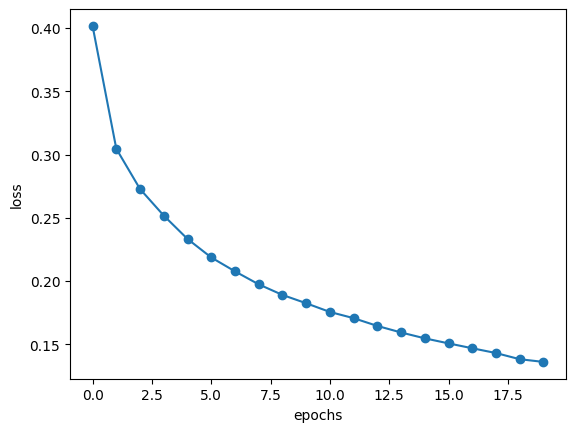

In [ ]:
plt.plot(losses, 'o-')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
# model load
# MODEL_BEST_WEIGHTS_PATH
# 저장된 모델 상태를 불러옵니다.
model_state = torch.load(MODEL_BEST_WEIGHTS_PATH, weights_only=True)

# 모델 상태를 현재 모델에 로드합니다.
model.load_state_dict(model_state['ldm'])
model.eval();

### Sampling

In [ ]:
alpha = MyDataset.alpha.to(device)
alpha_bar = MyDataset.alpha_bar.to(device)
beta = MyDataset.beta.to(device)
T = MyDataset.T

잠재 변수와 모양이 같은 노이즈 32개를 준비합니다. 이 노이즈가 32개의 이미지로 변환될 텐데 8개씩 끊어서 `hero`, `side-facing`, `food`, `spell` 순으로 컨디션을 입력하겠습니다.

In [ ]:
# 샘플링 단계동안 생성된 이미지를 일정 간격마다 저장할 리스트를 준비
N = 32 # 모델에 입력할 샘플 개수

# noise
x = torch.randn(size=(N, LATENT_EMB_DIM, LATENT_HEIGHT, LATENT_WIDTH)).to(device)

# condition
ctx = torch.zeros(N, 5).to(device).float()
for i, t in enumerate([0, 4, 2, 3]):
    s = i + 7*i
    e = s + 8
    ctx[s:e, t] = 1.

In [ ]:
intermediate = []
save_rate = 20

with torch.no_grad():  # 그라디언트 추적 비활성화
    for t in tqdm(range(T, 0, -1)):
        if t > 1:
            z = torch.randn(size=(N, LATENT_EMB_DIM, LATENT_HEIGHT, LATENT_WIDTH)).to(device)
        else:
            z = torch.zeros((N, LATENT_EMB_DIM, LATENT_HEIGHT, LATENT_WIDTH)).to(device)

        t_torch = torch.tensor([[t]]*N, dtype=torch.float32).to(device)

        eps_theta = model(x, t_torch, ctx)

        x = (1 / torch.sqrt(alpha[t])) * \
            (x - ((1-alpha[t])/torch.sqrt(1-alpha_bar[t]))*eps_theta) + torch.sqrt(beta[t])*z

        if t % save_rate == 0 or t == T or t < 8:
            intermediate.append(x)

        # Clean up memory
        del z, t_torch, eps_theta
        torch.cuda.empty_cache()


100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.29it/s]


torch.Size([32, 3, 16, 16])
(16, 512, 3)


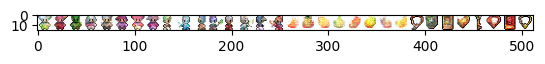

In [ ]:
predictions = vae.decode(x)
print(predictions.shape)

pred = predictions.permute(2, 0, 3, 1).reshape(IMAGE_SIZE, -1, 3).cpu().detach().numpy().clip(0,1)
print(pred.shape) # (16, 512, 3) -> (16*4, 16*8, 3)

plt.imshow(pred)
plt.show()

노이즈 제거 과정에서 저장된 중간 단계 잠재 변수를 VAE로 모두 디코딩하고 이를 애니메이션과 gif파일로 구성합니다.

In [ ]:
# 노이즈 제거 과정에서 담아둔 단계별 잠재 변수를 단계별로 디코딩하고
# 아래쪽 애니메이션 만들 때 사용
intermediate_img = []

for frame in intermediate:
    # 디코딩된 이미지의 모임 (32, 3, 16, 16)
    predictions = vae.decode(frame)
    intermediate_img.append(predictions.detach().cpu().numpy())

# [(32, 3, 16, 16), ..., (32, 3, 16, 16)] => (32, 32, 3, 16, 16)
intermediate_img = np.stack(intermediate_img)

# (frame, sample, C, H, W)
# 32단계에서 32개의 이미지를 저장
# Save 32 images at step 32
intermediate_img.shape


(32, 32, 3, 16, 16)

In [ ]:
def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))

    return (x - xmin) / (xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)

    for t in range(n_t): # 32 프레임에
        for s in range(n_s): # 32 샘플에 대해서
            # 모든 프레임에 모든 이미지를 [0,1]로 노멀라이즈
            nstore[t,s] = unorm(store[t,s])

    return nstore

def plot_sample(x_gen_store, n_sample, nrows, save_dir, fn,  w, save=False):
    # x_gen_store:(frame, sample, C, H, W)
    ncols = n_sample//nrows

    # change to Numpy image format (h,w,channels) vs (channels,h,w)
    sx_gen_store = np.moveaxis(x_gen_store, 2, 4)

    # unity norm to put in range [0,1] for np.imshow
    # nsx_gen_store: (32, 32, 16, 16, 3)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))

    def animate_diff(i, store):
        plots = []

        for row in range(nrows):
            for col in range(ncols):
                sample_no = (row*ncols)+col
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])

                if sample_no % ncols == 0:
                    label = LABEL_NAMES[np.argmax(ctx.cpu().numpy(), axis=1)[sample_no]]
                    axs[row, col].set_ylabel(label, rotation=90, labelpad=10)
                plots.append( axs[row, col].imshow( store[ i, sample_no ] ) )

        return plots

    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],
                        interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    fig.suptitle(f"Conditional generation by {SWITCH}", fontsize=16)

    plt.close()

    if save:
        file_path = os.path.join(save_dir, f"{fn}_{SWITCH}_w{w}.gif")
        ani.save(file_path, dpi=100, writer=PillowWriter(fps=w))
        print('saved gif at ' + file_path)

    return ani

In [ ]:
ani_ddpm = plot_sample(intermediate_img, 32, 4, model_weights_dir, "ani", 5, True)

saved gif at assets\LDM_QKV_VAE_4\ani_QKV_w5.gif


In [ ]:
from IPython.display import HTML

HTML(ani_ddpm.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

지금까지 LDM 모델을 구체적으로 어떻게 구현하는지 알아봤습니다. 이 저장소를 통해 이미지 생성에서 노이즈 제거, 멀티 헤드 어텐션이 어떻게 작동하는지 이해하셨길 바랍니다. [en] So far, we have explored how to implement the LDM model in detail. Through this repository, I hope you have gained an understanding of how noise removal, image generation, and multi-head attention work.